In [1]:
import numpy as np
import scipy
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import bayesflow as bf
import tensorflow as tf
import tensorflow_probability as tfp

from utils import matplotlib_style
cor, pal = matplotlib_style()

# Set random seed
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

/Users/mrazo/Library/Caches/pypoetry/virtualenvs/scrappy-jDg5b02t-py3.11/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Two-state promoter distribution

In [25]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp = np.frompyfunc(
    lambda x, y, z: mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=100)), 3, 1
)


def log_p_m(mRNA, kp_on, kp_off, rm, gm=1):
    '''
    Computes the log probability lnP(m) for a two-state promoter model, i.e. the
    probability of having m mRNA.

    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.
    kp_on : float.
        rate of activation of the promoter in the chemical master equation
    kp_off : float.
        rate of deactivation of the promoter in the chemical master equation
    rm : float.
        production rate of the mRNA
    gm : float.
        1 / half-life time for the mRNA.

    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)

    # Compute the probability
    lnp = scipy.special.gammaln(kp_on / gm + mRNA) \
        - scipy.special.gammaln(mRNA + 1) \
        - scipy.special.gammaln((kp_off + kp_on) / gm + mRNA) \
        + scipy.special.gammaln((kp_off + kp_on) / gm) \
        - scipy.special.gammaln(kp_on / gm) \
        + mRNA * np.log(rm / gm) \
        + float(np_log_hyp(
            kp_on / gm + mRNA,
            (kp_off + kp_on) / gm + mRNA,
            -rm / gm
        ))

    return lnp

Let's look at an example distribution.

Text(0, 0.5, 'Probability')

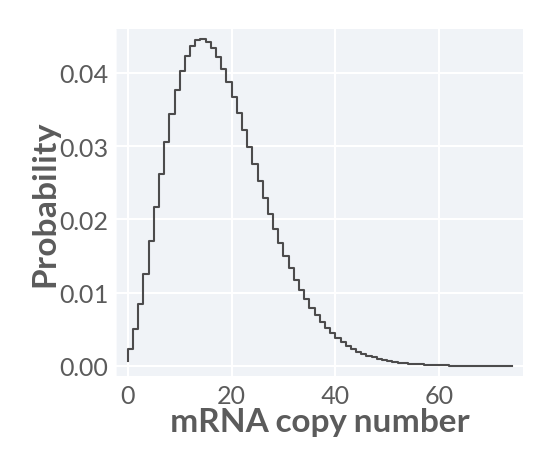

In [26]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 103

# Define range of mRNA
m_range = np.arange(0, 75)

# Evaluate the log probability
logP = [log_p_m(m, k_on, k_off, r_m) for m in m_range]

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

## Prior distribution function

Let's define the function that samples parameters from the prior distribution.

In [27]:
def prior_fn():
    # Prior on k_on rate
    k_on = rng.lognormal(1, 1)
    # Prior on k_off rate
    k_off = rng.gamma(2, 2)
    # Prior on rate of transcription r
    r = rng.lognormal(3, 3)

    return np.float32(np.array([k_on, k_off, r]))

We can now define the `BayesFlow` `simulation.Prior` object and sample from the
prior distribution.

In [28]:
# Define parameter names
param_names = ['k_on', 'k_off', 'r']

# Define prior simulator
prior = bf.simulation.Prior(
    prior_fun=prior_fn,
    param_names=param_names,
)

# Draw samples from the prior
prior(10)

{'prior_draws': array([[1.2056983e+00, 2.3717883e+00, 1.3165863e+01],
        [7.8930311e+00, 3.7554960e+00, 8.9856046e-01],
        [5.0931787e-01, 2.2287564e+00, 4.6621429e+01],
        [1.5925632e+01, 3.6811419e+00, 4.4911699e+00],
        [8.3115101e-01, 1.4107995e+00, 1.1913282e+04],
        [1.1955583e+00, 6.0008373e+00, 3.2855984e+02],
        [3.9946301e+00, 2.9450324e+00, 2.8168998e+00],
        [4.2464027e+00, 2.2911735e+00, 4.3438992e-01],
        [3.2303417e+00, 9.2988071e+00, 1.4070565e+01],
        [3.6176555e+00, 7.9703217e+00, 5.8545451e+00]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

## Likelihood function

Next, we can define the likelihood function. In this case, we will use the
`log_p_m` function defined above to compute the log probability of the mRNA copy
number given the parameters of the model.

### Naive likelihood function

For the first attempt, we will try to compute the likelihood function by 
evaluating the log probability of the mRNA copy number given the parameters for
a fixed range of mRNA copy numbers. After having these probabilities, we can
sample from the distribution to simulate UMI counts.

In [29]:
def likelihood_fn(params, n_obs=10_000, m_range=range(0, 400)):
    # Unpack parameters
    k_on, k_off, r = params
    # Compute the log probability over m_range
    logP = [log_p_m(m, k_on, k_off, r) for m in m_range]
    # Convert log probabilities to probabilities
    P = np.exp(logP)
    # Normalize the probabilities to use as weights
    P /= P.sum()
    # Generate random samples using these weights
    return np.float32(np.random.choice(m_range, size=n_obs, p=P))

Let's define the `BayesFlow` `simulation.Simulator` object and the generative
model.

In [43]:
# Define Likelihood simulator function for BayesFlow
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fn)

# Build generative model
model = bf.simulation.GenerativeModel(prior, simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Next, let's time how long it takes to simulate 10 datasets.

In [44]:
%time model(10)

CPU times: user 604 ms, sys: 2.83 ms, total: 606 ms
Wall time: 606 ms


{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[4.2164483e+00, 5.9608021e+00, 2.4523638e+01],
        [1.3533407e+00, 6.5968823e+00, 2.0998813e+02],
        [2.2464449e+00, 7.3642178e+00, 4.7312202e+03],
        [5.6450253e+00, 6.9897151e-01, 5.9689051e-01],
        [1.6188567e+00, 8.9558802e+00, 2.4675078e+00],
        [9.8637629e-01, 3.4186947e+00, 2.6820440e+00],
        [3.7136288e+00, 7.2946458e+00, 2.0777835e-02],
        [3.6853545e+00, 3.5228038e+00, 2.5622192e+03],
        [3.4533569e-01, 2.0281961e+00, 1.7468286e-01],
        [1.1892989e+01, 4.3777514e+00, 3.6225166e+00]], dtype=float32),
 'sim_non_batchable_context': None,
 'sim_batchable_context': None,
 'sim_data': array([[  3.,   9.,  19., ...,   9.,   7.,   6.],
        [ 46.,  60.,   6., ...,  33.,  40.,  60.],
        [194., 169., 351., ..., 244., 238., 394.],
        ...,
        [348., 363., 371., ..., 384., 383., 220.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]

One second is not bad. The problem is that having the range of 400 mRNA copy
number might not be enough for all the cases. Let's try to increase the range
up to 1000.

In [46]:
def likelihood_fn(params, n_obs=10_000, m_range=range(0, 1_000)):
    # Unpack parameters
    k_on, k_off, r = params
    # Compute the log probability over m_range
    logP = [log_p_m(m, k_on, k_off, r) for m in m_range]
    # Convert log probabilities to probabilities
    P = np.exp(logP)
    # Normalize the probabilities to use as weights
    P /= P.sum()
    # Generate random samples using these weights
    return np.float32(np.random.choice(m_range, size=n_obs, p=P))

In [47]:
# Define Likelihood simulator function for BayesFlow
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fn)

# Build generative model
model = bf.simulation.GenerativeModel(prior, simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [48]:
%time model(10)

CPU times: user 3.98 s, sys: 12.3 ms, total: 3.99 s
Wall time: 4 s


{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[3.9884148e+00, 6.6386480e+00, 1.3804200e+01],
        [1.1958658e+01, 1.7584218e+00, 3.6852322e+01],
        [6.3242106e+00, 3.3629224e+00, 2.6253436e+02],
        [6.3080087e+00, 4.9785147e+00, 1.0853797e+01],
        [3.6658594e-01, 9.4281530e+00, 2.7761255e+01],
        [1.0069899e+01, 6.7179197e-01, 1.6466637e-01],
        [1.2285857e+00, 4.6021991e+00, 4.6008335e+01],
        [6.6181719e-01, 2.2575698e+00, 1.6498604e+02],
        [3.1212745e+00, 5.7063909e+00, 9.8513550e+01],
        [1.3435652e+00, 2.8907530e+00, 2.3547044e+02]], dtype=float32),
 'sim_non_batchable_context': None,
 'sim_batchable_context': None,
 'sim_data': array([[ 7.,  5.,  4., ...,  7.,  3.,  7.],
        [34., 28., 22., ..., 36., 32., 25.],
        [80., 54., 72., ..., 78., 70., 87.],
        ...,
        [ 5.,  0., 35., ...,  6., 35.,  9.],
        [12., 34., 46., ..., 27., 18., 11.],
        [14., 19., 44., ...,

In [49]:
# Define the number of draws
n_draws = 100
# Draw samples from the generative model
%time model_draws = model(n_draws)

CPU times: user 51.1 s, sys: 194 ms, total: 51.3 s
Wall time: 51.4 s


Text(0, 0.5, 'ECDF')

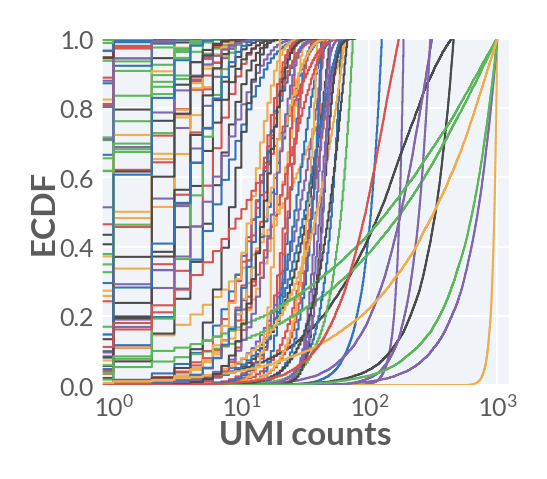

In [51]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Loop through the draws and plot the data
for m in range(n_draws):
    sns.ecdfplot(model_draws["sim_data"][m, :], ax=ax)

# Set x-axis to log scale
ax.set_xscale("log")

# Label axis
ax.set_xlabel("UMI counts")
ax.set_ylabel("ECDF")

In [6]:
def adaptive_m_range(k_on, k_off, r, gm=1, tol=1e-5, max_m=1000, step=10):
    """
    Adaptively determine the range of mRNA copy numbers (m_range) for the mRNA
    distribution based on the given parameters and a tolerance for cumulative
    probability.

    Parameters
    ----------
    - k_on (float): Rate of activation of the promoter.
    - k_off (float): Rate of deactivation of the promoter.
    - r (float): Production rate of the mRNA.
    - gm (float, optional): mRNA degradation rate. Default is 1.
    - tol (float, optional): Tolerance for cumulative probability. Default is
      1e-6.
    - max_m (int, optional): Maximum mRNA copy number to consider. Default is
      1000.
    - step (int, optional): Step size for mRNA copy number increments. Default
      is 10.

    Returns
    -------
    - m_range (numpy.ndarray): Array of mRNA copy numbers to consider.
    - log_probs (numpy.ndarray): Array of log probabilities corresponding to
      m_range.
    """
    # Initialize list to store mRNA copy numbers
    m_values = []
    # Initialize list to store log probabilities
    log_probs = []
    # Initialize cumulative probability
    cumulative_prob = 0
    # Start with mRNA copy number 0
    m = 0

    # Loop until cumulative probability reaches (1 - tol) or m exceeds max_m
    while cumulative_prob < (1 - tol) and m < max_m:
        # Generate a chunk of mRNA copy numbers
        m_chunk = np.arange(m, m + step)
        # Compute log probabilities for the current chunk
        log_prob_chunk = np.array(
            [log_p_m(mi, k_on, k_off, r, gm) for mi in m_chunk]
        )

        # Append the current chunk of mRNA copy numbers to the list
        m_values.extend(m_chunk)
        # Append the current chunk of log probabilities to the list
        log_probs.extend(log_prob_chunk)

        # Convert log probabilities to probabilities
        prob_chunk = np.exp(log_prob_chunk)
        # Update cumulative probability
        cumulative_prob += np.sum(prob_chunk)

        # Increment m by the step size
        m += step

        # Break the loop if all probabilities in the chunk are NaN
        if np.all(np.isnan(prob_chunk)):
            break

    # Return the mRNA copy numbers and corresponding log probabilities as numpy
    # arrays
    return np.array(m_values), np.array(log_probs)

In [33]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 103

# Adaptively determine the range of mRNA copy numbers
m_range = adaptive_m_range(k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range[0], np.exp(m_range[1]))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

Text(0, 0.5, 'Probability')

In [ ]:
def adaptive_likelihood_fn(params, n_obs=10_000, tol=1e-5, max_m=1000, step=10):
    """
    Likelihood function with adaptive m_range selection.

    This function generates random samples based on the mRNA distribution by
    adaptively determining the range of mRNA copy numbers (m_range) using the
    given parameters and a tolerance for cumulative probability.

    Parameters
    ----------
    - params (tuple): A tuple containing (k_on, k_off, r)
        - k_on (float): Rate of activation of the promoter.
        - k_off (float): Rate of deactivation of the promoter.
        - r (float): Production rate of the mRNA.
    - n_obs (int, optional): Number of observations to generate. Default is
      10,000.
    - tol (float, optional): Tolerance for cumulative probability in
      adaptive_m_range. Default is 1e-6.
    - max_m (int, optional): Maximum mRNA copy number to consider in
      adaptive_m_range. Default is 1000.
    - step (int, optional): Step size for mRNA copy number increments in
      adaptive_m_range. Default is 10.

    Returns
    -------
    - numpy.ndarray: Randomly generated samples based on the distribution.
    """
    # Unpack the parameters
    k_on, k_off, r = params

    # Adaptively determine the mRNA copy number range and corresponding log
    # probabilities
    m_range, log_probs = adaptive_m_range(
        k_on, k_off, r, tol=tol, max_m=max_m, step=step
    )

    # Convert log probabilities to probabilities

    # Find the maximum log probability for numerical stability
    max_log_prob = np.max(log_probs)
    # Exponentiate the log probabilities and normalize
    P = np.exp(log_probs - max_log_prob)
    # Normalize the probabilities to sum to 1
    P /= P.sum()

    # Generate random samples using the normalized probabilities as weights
    return np.float32(np.random.choice(m_range, size=n_obs, p=P))

In [ ]:
# def likelihood_fn(params, n_obs=10_000, m_range=range(0, 400)):
#     # Unpack parameters
#     k_on, k_off, r = params
#     # Compute the log probability over m_range
#     logP = [log_p_m(m, k_on, k_off, r) for m in m_range]
#     # Convert log probabilities to probabilities
#     P = np.exp(logP)
#     # Normalize the probabilities to use as weights
#     P /= P.sum()
#     # Generate random samples using these weights
#     return np.float32(np.random.choice(m_range, size=n_obs, p=P))

In [ ]:
# Define Likelihood simulator function for BayesFlow
simulator = bf.simulation.Simulator(simulator_fun=adaptive_likelihood_fn)

# Build generative model
model = bf.simulation.GenerativeModel(prior, simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Let's look at the ECDF for multiple samples from the prior distribution.

In [ ]:
# Define the number of draws
n_draws = 100
# Draw samples from the generative model
model_draws = model(n_draws)

KeyboardInterrupt: 

Text(0, 0.5, 'ECDF')

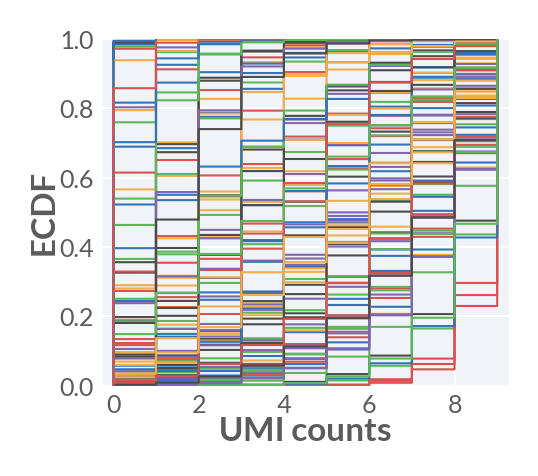

In [ ]:

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Loop through the draws and plot the data
for m in range(n_draws):
    sns.ecdfplot(model_draws["sim_data"][m, :], ax=ax)

# Label axis
ax.set_xlabel("UMI counts")
ax.set_ylabel("ECDF")